In [1]:
%matplotlib inline
import sys
sys.path.append("../")
sys.path.append('/home/hao/Research/probtorch/')
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from utils import *
from objectives import *
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
import time
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [4]:
N = 300
K = 3
D = 2

## Model Parameters
SAMPLE_SIZE = 10
NUM_HIDDEN1 = 8
STAT_SIZE = 8
NUM_LATENTS =  D
## Training Parameters
SAMPLE_DIM = 0
BATCH_DIM = 1
BATCH_SIZE = 20
NUM_EPOCHS = 10000
LEARNING_RATE = 1e-3
CUDA = torch.cuda.is_available()
PATH = 'gibbs-mu'

gpu2 = torch.device('cuda:1')

In [5]:
Xs = torch.from_numpy(np.load('rings_dataset/obs.npy')).float()
STATES = torch.from_numpy(np.load('rings_dataset/states.npy')).float()
OBS_MU = torch.from_numpy(np.load('rings_dataset/obs_mu.npy')).float()
NUM_SEQS = Xs.shape[0]
NUM_BATCHES = int((Xs.shape[0] / BATCH_SIZE))

In [6]:
class Enc_mu(nn.Module):
    def __init__(self, num_obs=D,
                       num_hidden1=NUM_HIDDEN1,
                       num_stats=STAT_SIZE,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        
        self.neural_stats = nn.Sequential(
            nn.Linear(K+D, num_hidden1),
            nn.Tanh(),
            nn.Linear(num_hidden1, num_stats),
            nn.Tanh())
        self.mean_mu = nn.Sequential(
            nn.Linear(num_stats+D, int(0.5 * num_stats+ 0.5 * D)),
            nn.Tanh(),
            nn.Linear(int(0.5 * num_stats + 0.5 * D), D))
        
        self.mean_log_sigma = nn.Sequential(
            nn.Linear(num_stats+D, int(0.5 * num_stats+ 0.5 * D)),
            nn.Tanh(),
            nn.Linear(int(0.5 * num_stats + 0.5 * D), D))

        self.prior_mu = torch.zeros((K, D))
        self.prior_sigma = torch.ones((K, D)) * 4.0
        if CUDA:
            self.prior_mu = self.prior_mu.cuda().to(gpu2)
            self.prior_sigma = self.prior_sigma.cuda().to(gpu2)
        
    def forward(self, obs, states, sample_size, batch_size):
        neural_stats = self.neural_stats(torch.cat((obs, states), -1))
        _, _, _, stat_size = neural_stats.shape
        cluster_size = states.sum(-2)  
        cluster_size[cluster_size == 0.0] = 1.0 # S * B * K
        neural_stats_expand = neural_stats.unsqueeze(-1).repeat(1, 1, 1, 1, K).transpose(-1, -2) ## S * B * N * K * STAT_SIZE
        states_expand = states.unsqueeze(-1).repeat(1, 1, 1, 1, stat_size) ## S * B * N * K * STAT_SIZE
        sum_stats = (states_expand * neural_stats_expand).sum(2) ## S * B * K * STAT_SIZE
        mean_stats = sum_stats / cluster_size.unsqueeze(-1)
        
        c1 = torch.cat((self.prior_mu[0].repeat(batch_size, 1).repeat(sample_size, 1, 1), mean_stats[:,:,0,:]), -1)
        c2 = torch.cat((self.prior_mu[1].repeat(batch_size, 1).repeat(sample_size, 1, 1), mean_stats[:,:,1,:]), -1)
        c3 = torch.cat((self.prior_mu[2].repeat(batch_size, 1).repeat(sample_size, 1, 1), mean_stats[:,:,2,:]), -1)
        #
        q_mu_c1 = self.mean_mu(c1)
        q_mu_c2 = self.mean_mu(c2)
        q_mu_c3 = self.mean_mu(c3)
        q_sigma_c1 = self.mean_log_sigma(c1).exp()
        q_sigma_c2 = self.mean_log_sigma(c2).exp()
        q_sigma_c3 = self.mean_log_sigma(c3).exp() 
        q_mu = torch.cat((q_mu_c1.unsqueeze(-2), q_mu_c2.unsqueeze(-2), q_mu_c3.unsqueeze(-2)), -2)
        q_sigma = torch.cat((q_sigma_c1.unsqueeze(-2), q_sigma_c2.unsqueeze(-2), q_sigma_c3.unsqueeze(-2)), -2)
        
        q = probtorch.Trace()   
        p = probtorch.Trace()
        means = Normal(q_mu, q_sigma).sample()
        q.normal(q_mu, 
                 q_sigma, 
                 value=means, 
                 name='means')
        p.normal(self.prior_mu, 
                 self.prior_sigma, 
                 value=q['means'], 
                 name='means')    
        return q, p
        
def initialize():
    enc_mu = Enc_mu()
    if CUDA:
        enc_mu.cuda().to(gpu2)
    optimizer =  torch.optim.Adam(list(enc_mu.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))    
    return enc_mu, optimizer

In [7]:
enc_mu, optimizer = initialize()

In [9]:
EUBOs = []
ELBOs = []
ESSs = []

flog = open('results/log-' + PATH + '.txt', 'w+')
flog.write('EUBO\tELBO\tESS\n')
flog.close()
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    indices = torch.randperm(NUM_SEQS)
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        obs = Xs[batch_indices]
        states = STATES[batch_indices]
        data = shuffler(torch.cat((obs, states), -1)).repeat(SAMPLE_SIZE, 1, 1, 1)
        if CUDA:
            data = data.cuda().to(gpu2)
        obs =data[:, :, :, :2]
        states = data[:, :, :, 2:]
        eubo, elbo, ess = Eubo_gibbs_mu(enc_mu, obs, states, K, D, SAMPLE_SIZE, BATCH_SIZE)
        ## gradient step
        eubo.backward()
        optimizer.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()
    EUBOs.append(EUBO / NUM_BATCHES)
    ELBOs.append(ELBO / NUM_BATCHES)
    ESSs.append(ESS / NUM_BATCHES) 
    flog = open('results/log-' + PATH + '.txt', 'a+')
    print('%.3f\t%.3f\t%.3f'
            % (EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES), file=flog)
    flog.close()
    time_end = time.time()
    print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f (%ds)'
            % (epoch, EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES, 
               time_end - time_start))


epoch=0, EUBO=-71996.473, ELBO=-283786.437, ESS=1.000 (1s)
epoch=1, EUBO=-35922.725, ELBO=-212671.791, ESS=1.000 (1s)
epoch=2, EUBO=-17757.550, ELBO=-115616.988, ESS=1.000 (1s)
epoch=3, EUBO=-10730.843, ELBO=-63883.191, ESS=1.001 (1s)
epoch=4, EUBO=-7344.364, ELBO=-32960.156, ESS=1.002 (1s)
epoch=5, EUBO=-4976.199, ELBO=-19640.659, ESS=1.004 (1s)
epoch=6, EUBO=-3116.573, ELBO=-12463.681, ESS=1.010 (1s)
epoch=7, EUBO=-1496.010, ELBO=-7089.406, ESS=1.027 (1s)
epoch=8, EUBO=-730.205, ELBO=-4186.491, ESS=1.056 (1s)
epoch=9, EUBO=-451.765, ELBO=-3048.479, ESS=1.088 (1s)
epoch=10, EUBO=-171.064, ELBO=-2564.316, ESS=1.112 (1s)
epoch=11, EUBO=-78.846, ELBO=-2350.044, ESS=1.135 (1s)
epoch=12, EUBO=5.368, ELBO=-2112.320, ESS=1.165 (1s)
epoch=13, EUBO=30.614, ELBO=-1988.680, ESS=1.196 (1s)
epoch=14, EUBO=93.807, ELBO=-1829.025, ESS=1.225 (1s)
epoch=15, EUBO=101.342, ELBO=-1700.749, ESS=1.253 (1s)
epoch=16, EUBO=150.042, ELBO=-1597.110, ESS=1.273 (1s)
epoch=17, EUBO=163.016, ELBO=-1441.408, ESS=1.

KeyboardInterrupt: 

In [10]:
def sample_single_batch(num_seqs, N, K, D, sample_size, batch_size):
    indices = torch.randperm(num_seqs)
    batch_indices = indices[0*batch_size : (0+1)*batch_size]
    obs = Xs[batch_indices]
    states = STATES[batch_indices]
    obs_mu_t = OBS_MU[batch_indices]
    data = shuffler(torch.cat((obs, states), -1)).repeat(sample_size, 1, 1, 1)
    if CUDA:
        data = data.cuda().to(gpu2)
    obs = data[:,:,:,:2]
    states = data[:,:,:,2:]
    return obs, states, obs_mu_t

In [11]:
obs, states, obs_mu_t = sample_single_batch(NUM_SEQS, N, K, D, SAMPLE_SIZE, batch_size=25)
q, p = enc_mu(obs, states, SAMPLE_SIZE, batch_size=25)

In [12]:
def plot_samples(obs, states, obs_mu_t, q, batch_size):
    colors = ['r', 'b', 'gold']
    fig = plt.figure(figsize=(25,25))
    xs = obs[0].cpu()
    zs = states[0].cpu()
    mu_mu = q['means'].dist.loc[0].cpu().data.numpy()
    mu_sigma = q['means'].dist.scale[0].cpu().data.numpy()
    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        x = xs[b].data.numpy()
        z = zs[b].data.numpy()
        mu_b_t = obs_mu_t[b].data.numpy()
        mu_mu_b = mu_mu[b]
        mu_sigma2_b = mu_sigma[b]**2
        assignments = z.argmax(-1)
        for k in range(K):
            cov_k = np.diag(mu_sigma2_b[k])
            xk = x[np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k])
            ax.scatter(mu_b_t[k, 0], mu_b_t[k, 1], c=colors[k])
            plot_cov_ellipse(cov=cov_k, pos=mu_mu_b[k], nstd=2, ax=ax, alpha=0.2, color=colors[k])
        ax.set_ylim([-5, 5])
        ax.set_xlim([-5, 5])
#     plt.savefig('results/modes-' + PATH + '.svg')

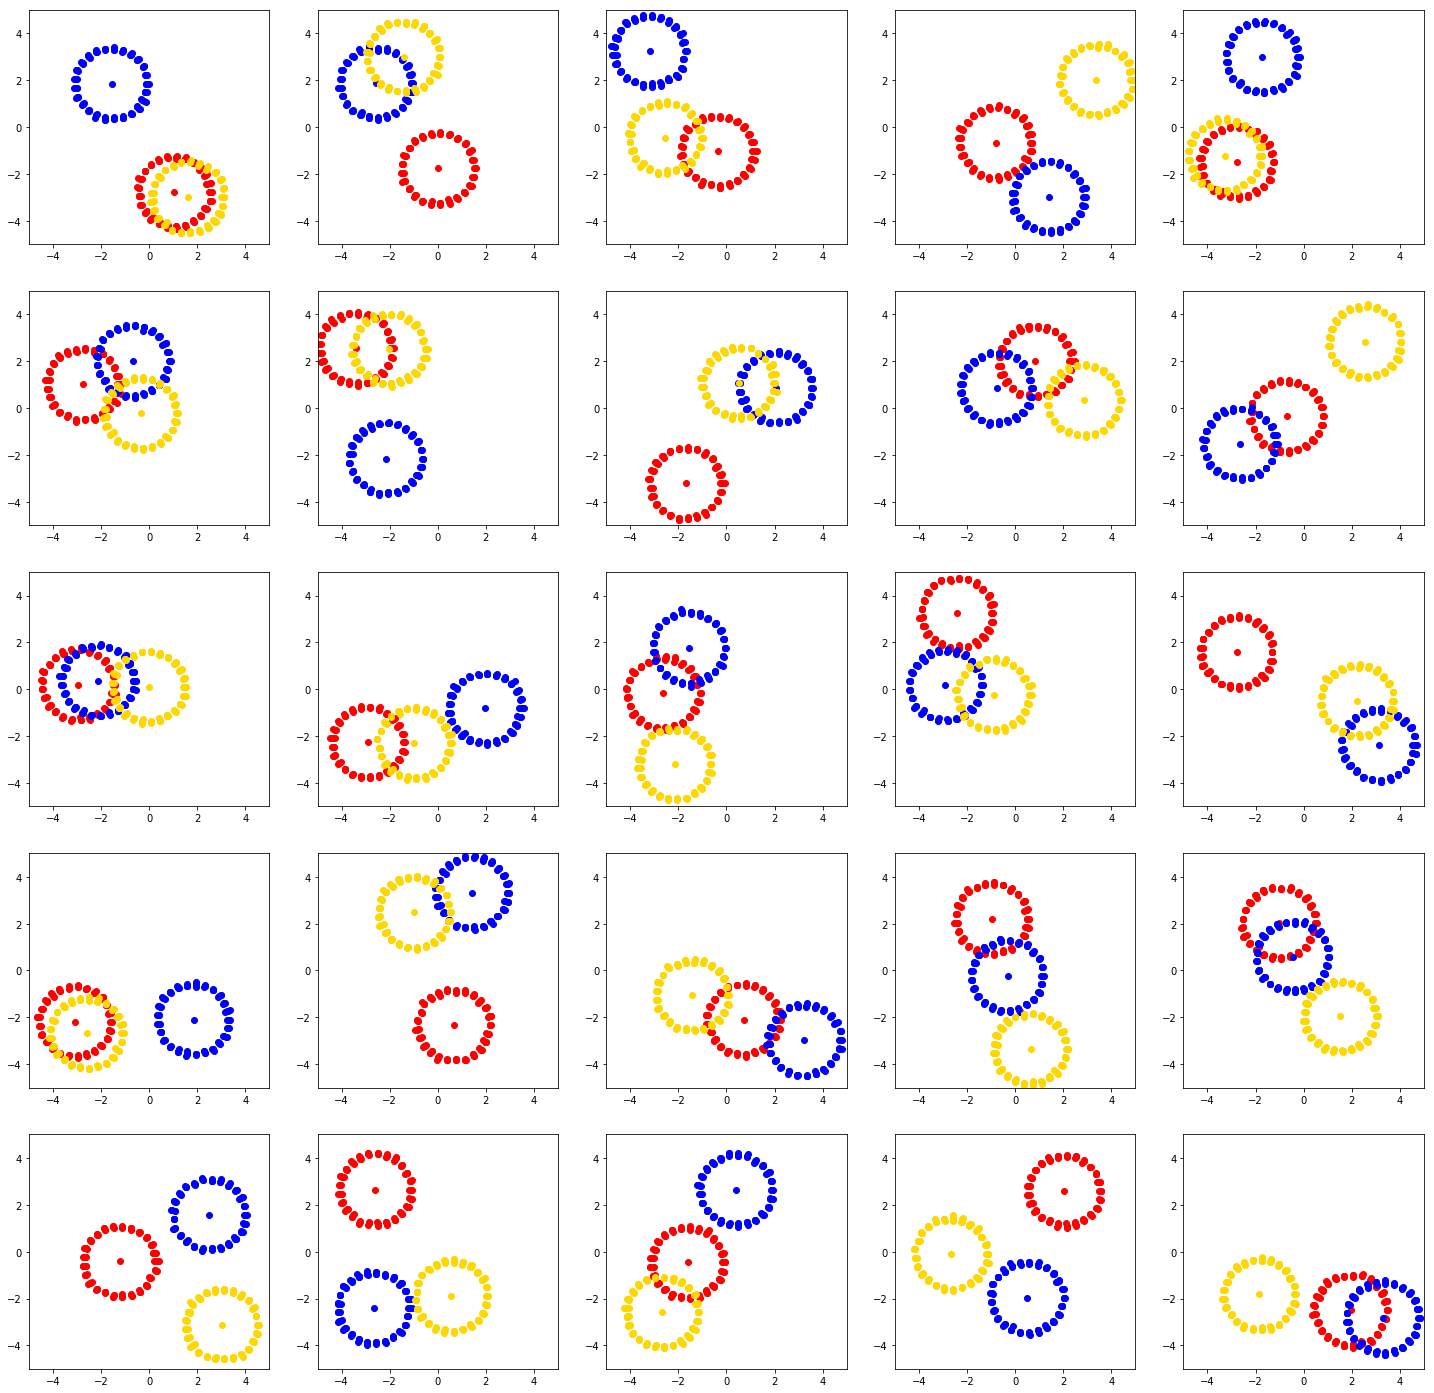

In [13]:
plot_samples(obs, states, obs_mu_t, q, batch_size=25)